# Middleburry Data, [link](https://vision.middlebury.edu/stereo/data/scenes2014/)

Ignoring [__Ibims1__](https://www.bgu.tum.de/en/lmf/research/datasets/ibims-1/) as it's no longer listed


    Each dataset consists of 2 views taken under several different illuminations and exposures. The files are organized as follows:
    SCENE-{perfect,imperfect}/     -- each scene comes with perfect and imperfect calibration (see paper)
      ambient/                     -- directory of all input views under ambient lighting
        L{1,2,...}/                -- different lighting conditions
          im0e{0,1,2,...}.png      -- left view under different exposures
          im1e{0,1,2,...}.png      -- right view under different exposures
      calib.txt                    -- calibration information
      im{0,1}.png                  -- default left and right view
      im1E.png                     -- default right view under different exposure
      im1L.png                     -- default right view with different lighting
      disp{0,1}.pfm                -- left and right GT disparities
      disp{0,1}-n.png              -- left and right GT number of samples (* perfect only)
      disp{0,1}-sd.pfm             -- left and right GT sample standard deviations (* perfect only)
      disp{0,1}y.pfm               -- left and right GT y-disparities (* imperfect only)


In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Download

- Download the "10 evaluation training sets with GT" and "13 additional datasets with GT" into an input folder
- inflate them


In [ ]:
inp_dir = Path('./middleburry_data/zip_files_test')

for file in [_ for _ in inp_dir.iterdir() if _.suffix == '.zip']:
    print(file)
    !unzip {file} -d {file.parent}

## Restructure

Repo calls for following structure, keeping only rgb images

    |-middleburry/
    |---/rgb
    |------{rgb images.*}

In [18]:
inp_dir = Path('./middleburry_data/zip_files_test')
out_dir = Path('./middleburry_data/zip_files_test/middleburry/').resolve()

In [19]:
Path.mkdir(out_dir, parents=True, exist_ok=False)

In [ ]:
# grab folder name and add it to the file name to create a more sensible filename.
# going to put all the files in one folder
out_dir / 'rgb' / (file.parts[-2] + '_' + file.name)

- Calling the shell `cp` command from jupyter cell
- rename each file with it's parent folder
    - e.g. `PosixPath('./Couch-perfect/im1E.png')` transform into `PosixPath('./Couch-perfect-im1E.png')`

In [86]:
for directory in [_ for _ in inp_dir.iterdir()if _.is_dir()]:
    for file in [file for file in directory.iterdir() if file.suffix == '.png']:
        # print(file)
        # print(out_dir / (file.parts[-2] + '_' + file.name))
        !cp {file} {out_dir / 'rgb' / (file.parts[-2] + '_' + file.name)}

## Step 2. Generate whole-image estimations

Download midas weights from [MiDas-v2](https://github.com/intel-isl/MiDaS/tree/v2) and put in `BoostingMonocularDepth/mergenet_dataset_prepare/midas/model.pt`

Within the repo's `BoostingMonocularDepth/dataset_prepare/midas` folder run the following cell

In [38]:
!python ./dataset_prepare/midas/run.py --res 384 --input_dir {out_dir}/middleburry/rgb --output_dir {out_dir}/middleburry/whole_low_est
!python ./dataset_prepare/midas/run.py --res 672 --input_dir {out_dir}/middleburry/rgb --output_dir {out_dir}/middleburry/whole_high_est

out_dir should now have the following structure:

    |-middleburry/
    |---/rgb
    |------{rgb images.*}
    |---/whole_low_est
    |---/whole_high_est
    
Where `/whole_low_est` estimation has midas Depth outputs for a lower resolution, and similar for `whole_high_est`

In [63]:
img_sample = 'Adirondack-imperfect_im0.png'
rgb = outdir/ 'middleburry' / 'rgb' / img_sample
whole_low = outdir / 'middleburry' / 'whole_low_est' / img_sample
whole_high = outdir / 'middleburry' / 'whole_high_est' / img_sample

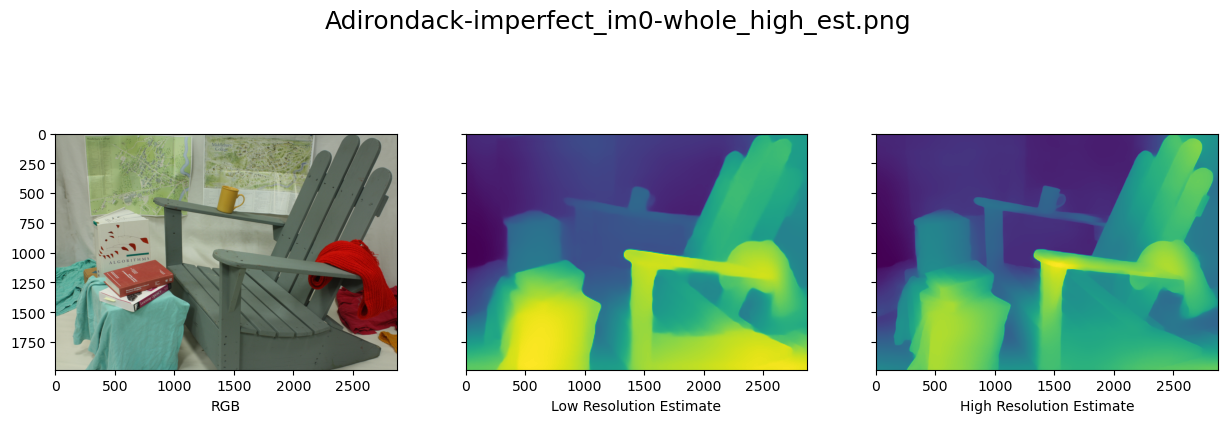

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=True, sharey=True)

ax[0].imshow(Image.open(rgb))
ax[0].set_xlabel('RGB')
ax[1].imshow(Image.fromarray(np.array(Image.open(whole_low)).astype("uint16")))
ax[1].set_xlabel("Low Resolution Estimate")
ax[2].imshow(Image.fromarray(np.array(Image.open(whole_high)).astype("uint16")))
ax[2].set_xlabel("High Resolution Estimate")

plt.suptitle(img_sample, fontsize=18)

plt.show();

## Step 3. Generate rgb proxy ground truth and low resolution estimations of the patches

This takes at least 20 mins (and on my older computer, multiple hours)

Edit `BoostingMonocularDepth/dataset_prepare/generate_crops.m` the line `root_dir=''` to point to the `out_dir` folder

Then from `BoostingMonocularDepth/dataset_prepare` run the following Matlab or Octave (requires image pkg):

    create_crops.m
    

## Step 4. Generate patch estimations for high resolution inputs of the network

Taking the rgb patches just generated, plug _each one_ through MiDas

In [ ]:
!python ./dataset_prepare/midas/run.py --res 672 --input_dir {out_dir}/mergenetdataset/train/rgb --output_dir {out_dir}/mergenetdataset/train/inner
!python ./dataset_prepare/midas/run.py --res 672 --input_dir {out_dir}/mergenetdataset/test/rgb --output_dir {out_dir}/mergenetdataset/test/inner

Dataset is complete and is located at `{out_dir}/mergenetdataset` with structure:

    |-mergenetdataset
    |---/train
    |------/gtfake
    |------/inner
    |------/outer
    |------/rgb
    |---/test
    |------/gtfake
    |------/inner
    |------/outer
    |------/rgb
    |-middleburry/
    |---/rgb
    |------{rgb images.*}
    |---/whole_low_est
    |---/whole_high_est


Here rgb contains patches of the original images, and `/gtfake` is proxy ground truth labels per patch. `/outer` is low res ground truth, so more objects. `/inner` is high resolution depth map patches, so more detailed.

In the example of the original repo they show how `/outer` while `/inner` captures seagulls

In [69]:
train_dir = Path('/mergenetdataset/train/')

patch_img = 'Adirondack-imperfect_im0_&0_0&.png'
gtfake = train_dir / 'gtfake' / patch_img
outer = train_dir / 'outer' / patch_img
inner = train_dir / 'inner' / patch_img
rgb = train_dir / 'rgb' / patch_img

In [48]:
img = Image.open(gtfake)
np.max(img), np.min(img)

(65535, 0)

Here looking at the mug, `/outer` doesn't show the handle as well as the ground truth. While `/inner` is much better but has artifacts in the empty space background

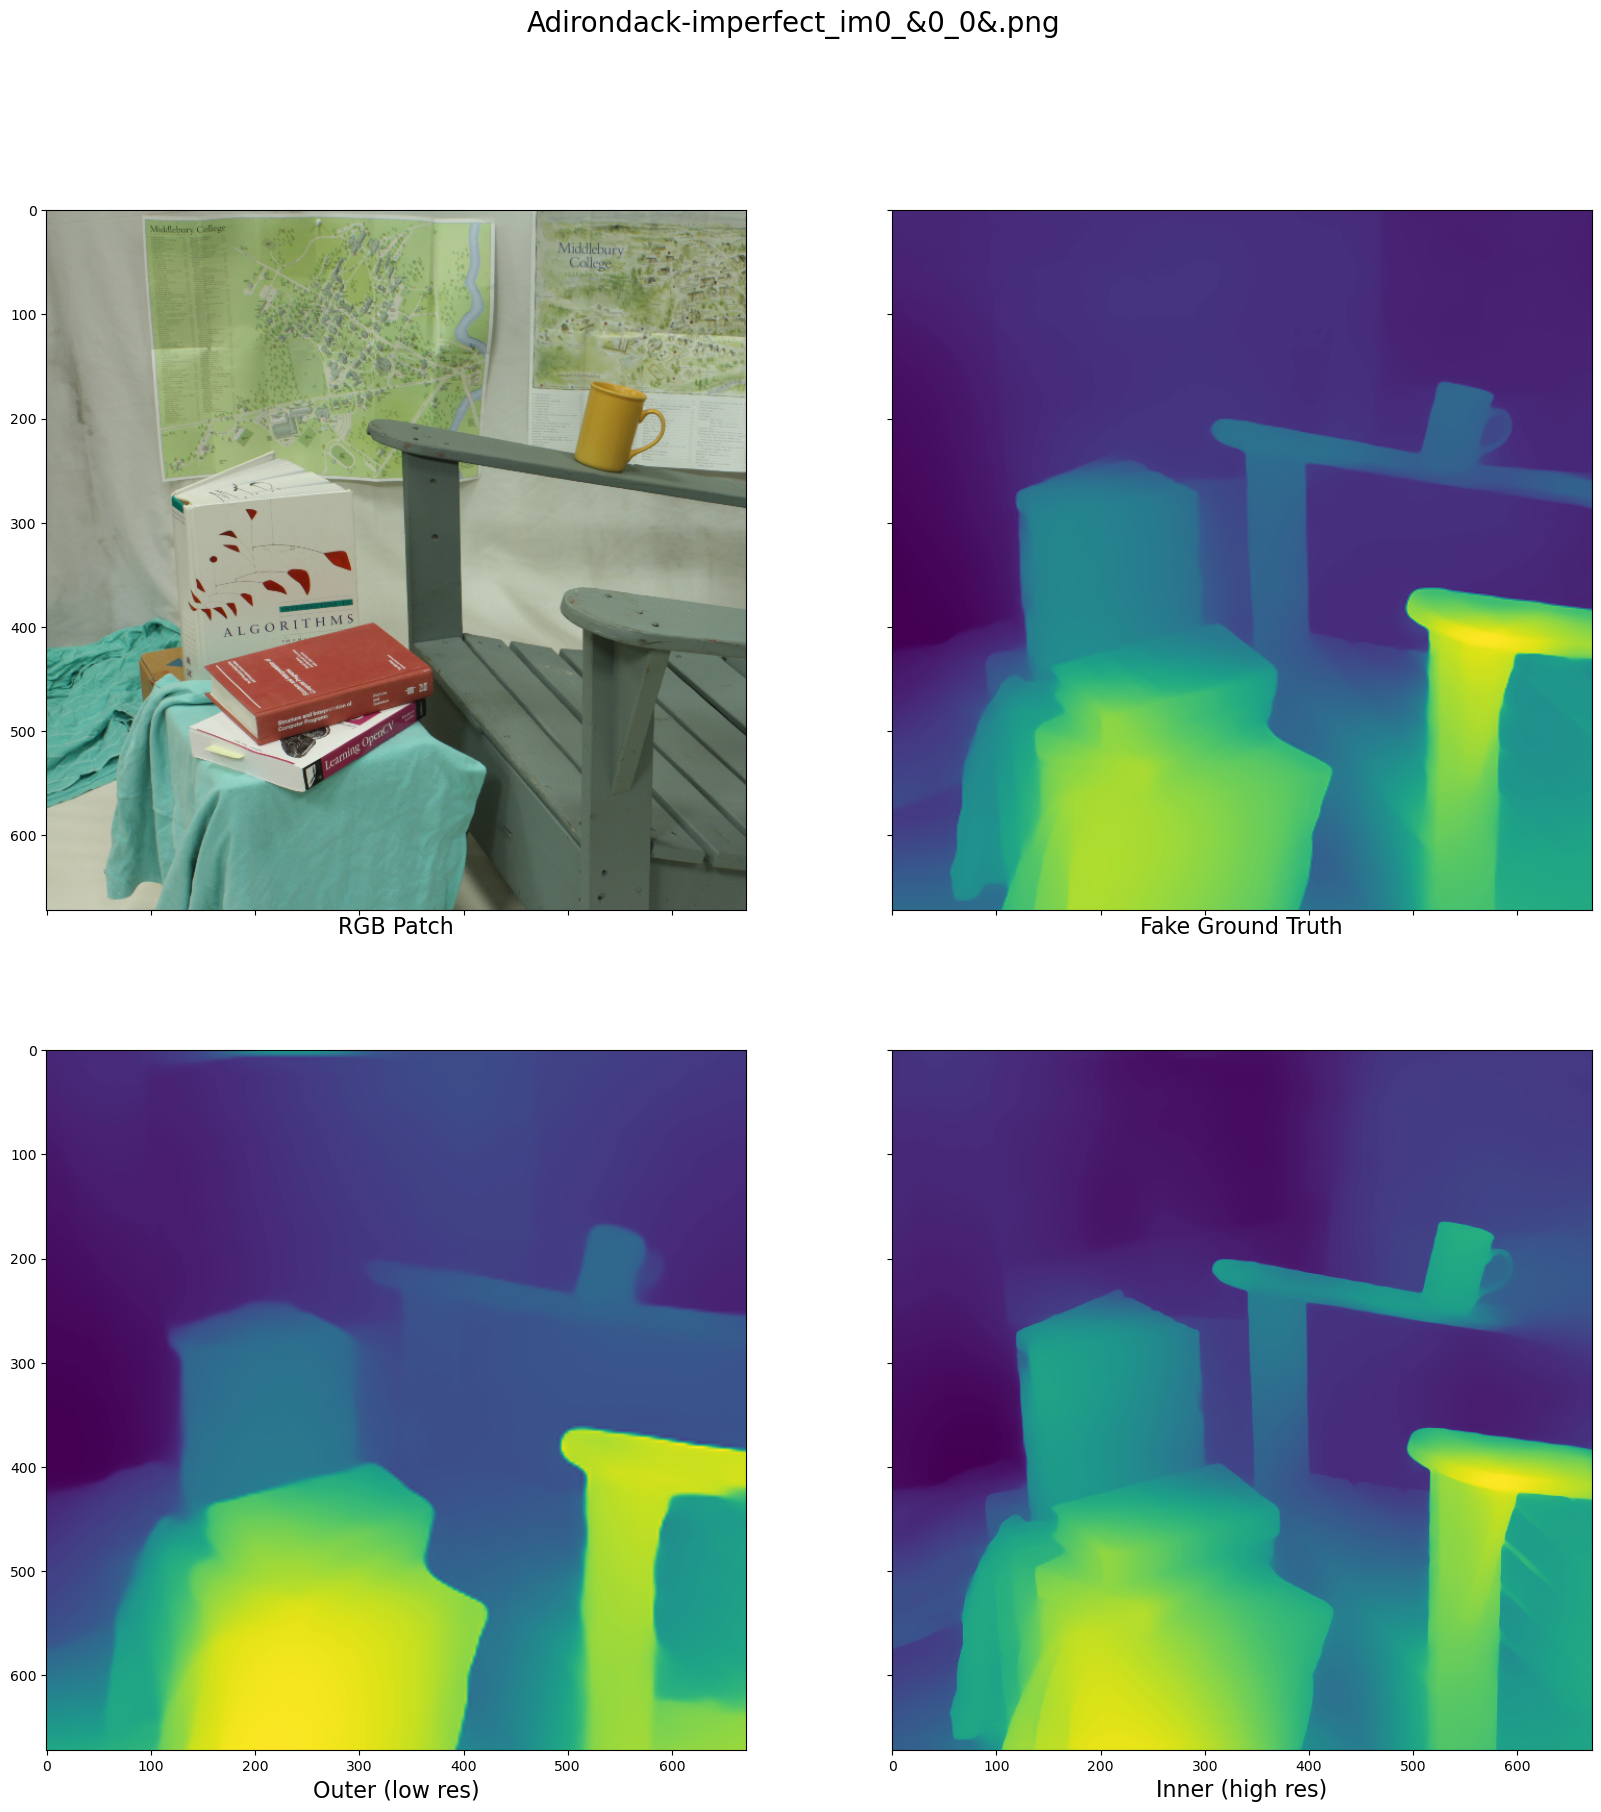

In [75]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20), sharex=True, sharey=True)
fs=16

ax=ax.flatten()

ax[0].imshow(Image.open(rgb))
ax[0].set_xlabel('RGB Patch', fontsize=fs)
ax[1].imshow(Image.fromarray(np.array(Image.open(gtfake)).astype("uint16")))
ax[1].set_xlabel("Fake Ground Truth", fontsize=fs)

ax[2].imshow(Image.fromarray(np.array(Image.open(outer)).astype("uint16")))
ax[2].set_xlabel("Outer (low res)", fontsize=fs)
ax[3].imshow(Image.fromarray(np.array(Image.open(inner)).astype("uint16")))
ax[3].set_xlabel("Inner (high res)", fontsize=fs)

plt.suptitle(patch_img, fontsize=20)
plt.show();